# factor analysis 

Factor Analysis is a part of Exploratory Data Analysis process which is commonly used for dimensionality reduction method. It is used to reduce a large number of variables into smaller number of variables.

**The primary goal of factor analysis is to reduce number of variables and find unobservable variables.**

## 1. Suitability Tests using KMO

The Kaiser-Meyer-Olkin (KMO) test in Python is used to assess the sampling adequacy of a dataset for factor analysis. It measures the proportion of variance among the variables that might be common variance, indicating how suitable the data is for dimensionality reduction techniques like Factor Analysis. when Values closer to 1 ,Indicate that the data is highly suitable for factor analysis, suggesting strong intercorrelations among variables.

In [2]:
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from factor_analyzer.factor_analyzer import FactorAnalyzer 

In [3]:
df = pd.read_csv("data/gold/traffic_weather_merged.csv")

df_fac = df[["temperature_c", "rain_mm", "humidity","wind_speed_kmh","air_pressure_hpa","visibility_m_weather", "accident_count","avg_speed_kmh", "vehicle_count"]]
scaler = StandardScaler()
df_fac = pd.DataFrame(scaler.fit_transform(df_fac), columns=df_fac.columns)

In [4]:
kmo_per_variable, kmo_total = calculate_kmo(df_fac)

print(f"KMO per variable: {kmo_per_variable}")
print(f"Overall KMO: {kmo_total}")

KMO per variable: [0.49875503 0.48463503 0.48347635 0.48489555 0.50292457 0.50972376
 0.48868379 0.4860144  0.50542038]
Overall KMO: 0.4936513899328474


as shown, the kmo result is very weak because the data is fully generated.

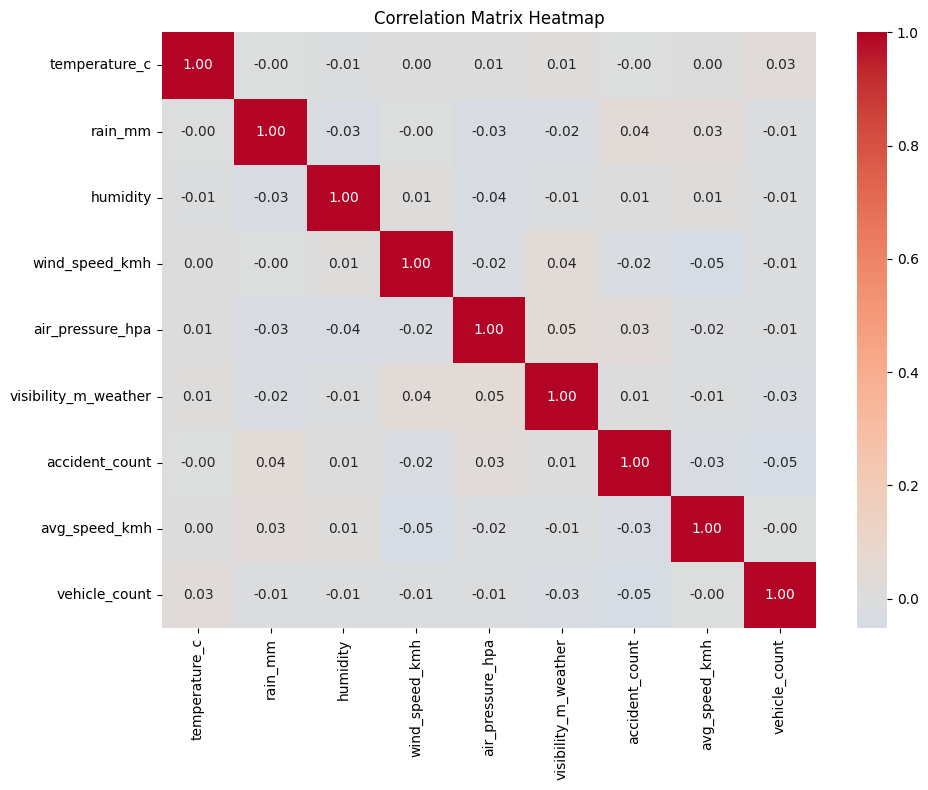

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_fac.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

The weak KMO result is expected and logical given the nature of the dataset. Since the data is fully synthetically generated without intentional correlations between variables, the correlation matrix displays uniformly weak relationships. This absence of strong intercorrelations among the variables indicates that factor analysis may not be suitable for this particular dataset, as factor analysis typically seeks to identify underlying common factors in correlated data.

In [6]:
fa = FactorAnalyzer(rotation='varimax')
fa.fit(df_fac)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [7]:
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
sorted_ev = sorted(ev, reverse=True)
print("Eigenvalues:", sorted_ev)

Eigenvalues: [1.1021440187966085, 1.077711962204832, 1.0512894977190006, 1.0224468645640927, 1.0010039644641655, 0.9931009712072824, 0.9412793074957638, 0.9200232948519762, 0.8910001186962786]


After sorting the eigenvalues, I was able to notice that three eigenvalues were greater than 1 so we can choose 5 factors.

In [8]:
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(df_fac)


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [9]:
factor_loadings_df = pd.DataFrame(fa.loadings_, 
                                  index=df_fac.columns,
                                  columns=['Factor1', 'Factor2', 'Factor3'])
print(factor_loadings_df)


                       Factor1   Factor2   Factor3
temperature_c         0.000376  0.023108  0.003601
rain_mm               0.030933 -0.074018 -0.050120
humidity             -0.003820 -0.081092  0.015721
wind_speed_kmh       -0.013790 -0.071462  0.387634
air_pressure_hpa      0.074224  0.399299  0.022330
visibility_m_weather  0.025249  0.115176  0.111559
accident_count        0.989861 -0.116386 -0.041254
avg_speed_kmh        -0.041936 -0.030726 -0.130908
vehicle_count        -0.057152 -0.022276 -0.027020


In [10]:
# Get top 3 loadings for each factor
for factor in ['Factor1', 'Factor2', 'Factor3']:
    print(f"\nTop 3 highest loadings for {factor}:")
    factor_data = factor_loadings_df[factor].sort_values(ascending=False).head(3)
    
    # Display with original (signed) values
    for var in factor_data.index:
        original_value = factor_loadings_df.loc[var, factor]
        print(f"  {var}: {original_value:.6f}")



Top 3 highest loadings for Factor1:
  accident_count: 0.989861
  air_pressure_hpa: 0.074224
  rain_mm: 0.030933

Top 3 highest loadings for Factor2:
  air_pressure_hpa: 0.399299
  visibility_m_weather: 0.115176
  temperature_c: 0.023108

Top 3 highest loadings for Factor3:
  wind_speed_kmh: 0.387634
  visibility_m_weather: 0.111559
  air_pressure_hpa: 0.022330


factor 1 > is influenced by accident count features, so we can rename it to **Accident Risk Factor**

factor 2 > is influenced by air pressure and visibility so we can rename it to **Atmospheric Conditions Factor**

factor 3 > is influenced by  wind_speed and visibility, so we can rename it to  **Weather Severity Factor**

In [11]:
factor_loadings_df = pd.DataFrame(fa.loadings_, 
                                  index=df_fac.columns,
                                  columns=['Accident Risk Factor', 'Atmospheric Conditions Factor', 'Weather Severity Factor'])


In [12]:
factor_loadings_df.to_csv("data/gold/factor_loadings.csv")


In [13]:
report = """
Factor 1: Accident Risk Factor
This factor is strongly dominated by accident_count, with an extremely high loading,
indicating that it represents the overall risk of traffic accidents.
Other weather-related variables contribute only marginally, suggesting that this factor
captures accident occurrence as an independent latent construct.

Factor 2: Atmospheric Conditions Factor
This factor loads primarily on air_pressure_hpa, with secondary contributions from
visibility and temperature. It reflects general atmospheric and weather conditions
that describe the state of the environment rather than direct traffic dynamics.

Factor 3: Weather Severity Factor
This factor is mainly influenced by wind_speed_kmh and visibility, representing
weather severity and variability that can affect driving conditions.
Although its direct influence on traffic variables is limited, it captures
environmental stress caused by adverse weather conditions.

Weather–Traffic Relationship:
The analysis suggests that accident risk emerges as a distinct latent factor,
largely independent of traffic flow variables.
Among weather variables, air_pressure_hpa shows the strongest contribution within
the atmospheric conditions factor, indicating it as the most influential weather
feature in the dataset.
"""


with open("data/gold/factor_interpretation.txt", "w") as f:
    f.write(report)